# Business Understanding and Set-up
Purpose: Ask relevant questions and define objectives for the problem that needs to be tackled
## Background
### About Kickstarter
In recent years, the range of funding options for projects created by individuals and small companies has expanded considerably. In addition to savings, bank loans, friends & family funding and other traditional options, crowdfunding has become a popular and readily available alternative. 

Kickstarter, founded in 2009, is one particularly well-known and popular crowdfunding platform. It has an all-or-nothing funding model, whereby a project is only funded if it meets its goal amount; otherwise no money is given by backers to a project.
A huge variety of factors contribute to the success or failure of a project — in general, and also on Kickstarter. Some of these are able to be quantified or categorized, which allows for the construction of a model to attempt to predict whether a project will succeed or not. The aim of this project is to construct such a model and also to analyse Kickstarter project data more generally, in order to help potential project creators assess whether or not Kickstarter is a good funding option for them, and what their chances of success are.

### Final Deliverables
- Slide deck PDF pushed to GitHub designed for non-technical stakeholders outlining findings and recommendations, as well as future work (10min presentation). 
- Jupyter notebook following PEP8 designed for data science / technical audience. 

### Things to think about
- Try different (at least 3) machine learning algorithms to check which performs best on the problem at hand
- What would be right performance metric: Precision, recall, accuracy, F1 score, or something else? (Check TPR?)
- Check for data imbalance

## Key Question
We are tasked by Kickstarter to come up with a model to predict viable targets for projects, in order for them to provide a good estimate for project creators (particularly as Kickstarter can influence certain parameters such as staff picks). 
* What would be a reasonable target **after the project creator enters key parameters**?
* What would be a reasonable adapted target **after Kickstarter specifies its parameters (e.g. spotlight, staff pick)**?


## Glossary
* **TARGET: SUCCESS** - New column with 1 for success, 0 for fail (alternative for target: converted_pledged_amount)
* **backers_count** - The number of supporters that actually invested in the project
* **blurb** - A short description of a book, film, or other product written for promotional purposes
* **category** - Main category the project falls in (e.g. "food", "music")
* **converted_pledged_amount** - Pledged amount of USD realised at the deadline, converted from "pledged" via "static_usd_rate", rounded
* **country** - Country of origin of the project
* **created_at** - Date when Project was created (UNIX Format)
* **creator** - 
* **currency** - Currency of the project (e.g. USD, GBP)
* **currency_symbol** - Symbol of the currency
* **currency_trailing_code** - Defines whether the currency codes are always shown after the amount, independent of the locale
* **current_currency** - Currency of the project (e.g. USD, GBP) : Same as currency
* **deadline** - Deadline of the project (can be used to analyze timeframes)
* **disable_communication** - 
* **file** - Corresponding csv-file where the entry was taken from
* **friends** - 208922 NaN and 300 empty lists
* **fx_rate** - Used to create 'converted_pledged_amount' from 'pledged', but does not always convert to dollars so can be dropped in favour of 'static_usd_rate' which always converts to dollars
* **goal** - Amount of USD the project asked for initially
* **id** / **project_id** - Unique project id (redundant, so "id" is dropped)
* **is_backing** - 208922 NaN and 300 empty lists
* **is_starrable** - 
* **is_starred** - 
* **launched_at** - Launch date of the project (can be used to analyze timeframes) / UNIX Format
* **location** - Location of the project
* **name** - Name of the project
* **permissions** - 208922 NaN and 300 empty lists
* **photo** - 
* **pledged** - Unconverted pledge amount as float
* **profile** - 
* **slug** - Creator-selected keyword id of the project
* **source_url** - Source of the data by categories
* **spotlight** - Spotlight allows creators to make a home for their project on Kickstarter after they've been successfully funded. Each creator can take control of their page and build a customized, central hub for news, updates, links to finished work, and anything else they want the world to know about their project
* **staff_pick** - Staff picks was a feature that highlighted promising projects on the site to give them a boost by helping them get exposure through the email newsletter and highlighted spots around the site. The old 'Kickstarter Staff Pick' badge.
* **state** - Was the project successful at the end of the day? state is a categorical variable divided into the levels successful, failed, live, cancelled, undefined and suspended. For the sake of clarity, we will only look at whether a project was successful or failed (hence, we will remove all projects that are not classified as one of the two). Projects that failed or were successful make up around 88% of all projects.
* **state_changed_at** - 
* **static_usd_rate** - "Rate of conversion from "currency" to USD
* **urls** - 
* **usd_pledged** - Pledged amount of USD realised at the deadline, converted from "pledged" via "static_usd_rate"
* **usd_type** - it is unclear what this column means, but it is unlikely to be necessary since all currency values will be converted to dollars, and other currency information has been dropped. (NaN where "current currency" is not USD)

## Variable Description
* **data_raw** - Originally imported dataset
* **data** - Main working dataset containing cleaned and refined data
* **data_insp** - Copy of data before 3 Data Cleaning used during 3.1 Inspection
* **data_clean** - Copy of data after 3 Data Cleaning used during 4 Data Exploration
* **data_results** - Main working dataset incl. predicted values and residuals from selected regression model
* **data_results_1..** - Interim results of the regression models
* ...

## Outcome/Recommendations
- As per the key question, a) five high-grade and b) five sub-par investment opportunities have been identified
- Optimal months to buy houses and year-on-year price movements still to be analyzed

## To-Do-List / Open Questions (with notes)
- Is the data/csv's [monthly snapshot data](https://aito.ai/example-gallery/predict-and-explain-a-kickstarter-campaign-success/)? i.e., are the multiple ID entries just projects that span multiple months? Shouldn't they be more then? --> working assumption: no, as the data in each csv file is spread over a decade
- Investigate TARGET: SUCCESS via "state": 
  - Should we drop all that are not successful or state? --> yes
  - Is there a connection between "canceled", "live", "suspended" and the occurrence of multiple ID's? --> yes, partly
- Do we have duplicate projects? --> yes, we have same IDs frequently. Only the entry with the highest usd_pledged is kept

## Import libraries (overarching)

In [121]:
# Import overarching libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import scipy as sc
from scipy.stats import kstest
from scipy.stats import zscore
import seaborn as sns
import math

import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

%matplotlib inline

#Subplots
from plotly.subplots import make_subplots
from numpy import median

## Dashboard
Purpose: Define global variables and visuals

In [337]:
random_state = 100
test_size = 0.2
scoring = "precision" # Reasoning: target "state" is distributed roughly 85:15, so both accuracy and f1_score can be optimized through 100% recall
pd.set_option('display.max_columns', 50)
sns.set(style="white")

# Data Mining
Purpose: Gather and scrape the data necessary for the project

In [123]:
# Import libraries
from numpy import loadtxt
import os, glob

In [124]:
# Import multiple csv files and merge into one dataframe
all_files = glob.glob(os.path.join("data", "*.csv"))
all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',')
    df['file'] = f.split('/')[-1]
    all_df.append(df)
data_raw = pd.concat(all_df, ignore_index=True, sort=True)

In [125]:
# Assign data_raw to data
data = data_raw.copy()

# Data Cleaning
Purpose: Fix the inconsistencies within the data and handle the missing values

In [126]:
# Import libraries
from datetime import datetime
import ast

## Inspection
Purpose: Getting a good sense of the data

In [127]:
# Create dataset for inspection
data_insp = data.copy()

In [128]:
# Display shape of "data"
data_insp.shape

(209222, 38)

In [129]:
# Display head(5) of "data_insp"
data_insp.head(6)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,file,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,USD,1552539775,False,Kickstarter040.csv,NaN,1.000000,28000.0,2108505034,NaN,False,NaN,1548223375,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",Babalus Children's Shoes,NaN,"{""key"":""assets/023/667/205/a565fde5382d6b53276...",28645.0,"{""id"":3508024,""project_id"":3508024,""state"":""in...",babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",28645.000000,international
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,USD,1504976459,False,Kickstarter040.csv,NaN,1.000000,1000.0,928751314,NaN,False,NaN,1502384459,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",The Ofrenda Oracle Deck,NaN,"{""key"":""assets/017/766/989/dd9f18c773a8546d996...",1950.0,"{""id"":3094785,""project_id"":3094785,""state"":""ac...",the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1950.000000,domestic
2,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,True,USD,1371013395,False,Kickstarter040.csv,NaN,1.000000,15000.0,928014092,NaN,False,NaN,1368421395,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...","Record Electra's Debut Album (Pop, Rock, Class...",NaN,"{""key"":""assets/011/433/681/489fd66f7861fefd8c8...",22404.0,"{""id"":359847,""project_id"":359847,""state"":""inac...",record-electras-debut-album-pop-rock-classical,https://www.kickstarter.com/discover/categorie...,True,False,successful,1371013395,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",22404.000000,international
3,3,The Mist of Tribunal is a turn-based card game...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,False,USD,1489425776,False,Kickstarter040.csv,NaN,1.308394,10000.0,596091328,NaN,False,NaN,1484245376,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",The Mist of Tribunal - A Card Game,NaN,"{""key"":""assets/015/091/198/216fbf1bdc3739e7971...",136.0,"{""id"":2825329,""project_id"":2825329,""state"":""in...",the-mist-of-tribunal-a-card-game,https://www.kickstarter.com/discover/categorie...,False,False,failed,1489425776,1.216066,"{""web"":{""project"":""https://www.kickstarter.com...",165.384934,domestic
4,3,"Livng with a brain impairment, what its like t...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,True,USD,1357763527,False,Kickstarter040.csv,NaN,1.000000,2800.0,998516049,NaN,False,NaN,1355171527,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",Help change the face of Brain Impairment,NaN,"{""key"":""assets/011/457/844/37ba63d35fefaba76e9...",2820.0,"{""id"":417385,""project_id"":417385,""state"":""inac...",help-change-the-face-of-brain-impairment,https://www.kickstarter.com/discover/categorie...,True,False,successful,1357763527,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2820.00000

In [130]:
# Display columns of "data"
data_insp.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'file', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

In [131]:
#datatest = data.converted_pledged_amount - data.usd_pledged

In [132]:
#datatest.sort_values(ascending=False).head()

In [133]:
#data.iloc[79591]

In [134]:
# Compare with random single csv file
data0 = pd.read_csv("data/Kickstarter015.csv")
data.shape

(209222, 38)

In [135]:
# Describe data (summary)
data_insp.describe().round(2)

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,id,launched_at,pledged,state_changed_at,static_usd_rate,usd_pledged
count,209222.00,209222.00,2.092220e+05,2.092220e+05,209222.00,2.092220e+05,2.092220e+05,2.092220e+05,209222.00,2.092220e+05,209222.00,209222.00
mean,145.42,12892.90,1.456089e+09,1.463033e+09,0.99,4.917604e+04,1.073222e+09,1.460206e+09,18814.03,1.462838e+09,1.01,12892.13
std,885.97,88894.14,6.339711e+07,6.305618e+07,0.21,1.179427e+06,6.198051e+08,6.309029e+07,322959.62,6.290421e+07,0.23,88901.24
min,0.00,0.00,1.240366e+09,1.241334e+09,0.01,1.000000e-02,8.624000e+03,1.240603e+09,0.00,1.241334e+09,0.01,0.00
25%,4.00,106.00,1.413317e+09,1.420607e+09,1.00,1.500000e+03,5.351054e+08,1.417639e+09,110.00,1.420485e+09,1.00,106.00
50%,27.00,1537.00,1.457895e+09,1.464754e+09,1.00,5.000000e+03,1.074579e+09,1.461924e+09,1556.00,1.464709e+09,1.00,1537.36
75%,89.00,6548.00,1.511595e+09,1.519437e+09,1.00,1.500000e+04,1.609369e+09,1.516694e+09,6887.20,1.519366e+09,1.00,6550.00
max,105857.00,8596474.00,1.552527e+09,1.557721e+09,1.88,1.000000e+08,2.147476e+09,1.552537e+09,81030744.00,1.552537e+09,1.72,8596474.58


In [136]:
# List datatypes (data.info())
data_insp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 38 columns):
backers_count               209222 non-null int64
blurb                       209214 non-null object
category                    209222 non-null object
converted_pledged_amount    209222 non-null int64
country                     209222 non-null object
created_at                  209222 non-null int64
creator                     209222 non-null object
currency                    209222 non-null object
currency_symbol             209222 non-null object
currency_trailing_code      209222 non-null bool
current_currency            209222 non-null object
deadline                    209222 non-null int64
disable_communication       209222 non-null bool
file                        209222 non-null object
friends                     300 non-null object
fx_rate                     209222 non-null float64
goal                        209222 non-null float64
id                          209

In [137]:
# List unique entries per column
data_insp.nunique()

backers_count                 3246
blurb                       180700
category                       169
converted_pledged_amount     31387
country                         22
created_at                  182158
creator                     208562
currency                        14
currency_symbol                  6
currency_trailing_code           2
current_currency                 5
deadline                    170854
disable_communication            2
file                            56
friends                          1
fx_rate                         67
goal                          5110
id                          182264
is_backing                       1
is_starrable                     2
is_starred                       2
launched_at                 182109
location                     15235
name                        181680
permissions                      1
photo                       182263
pledged                      44387
profile                     182265
slug                

In [138]:
# List correlation values
data_insp.corr()

,backers_count,converted_pledged_amount,created_at,currency_trailing_code,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,pledged,spotlight,staff_pick,state_changed_at,static_usd_rate,usd_pledged
backers_count,1.000000,0.805201,0.025763,0.010566,0.031456,-0.007194,0.003313,0.010019,-0.002635,-0.006344,0.031367,0.251022,0.123834,0.157586,0.031798,-0.000877,0.804528
converted_pledged_amount,0.805201,1.000000,0.031417,0.011129,0.036793,-0.005632,0.001674,0.010144,-0.001675,-0.006009,0.036437,0.311144,0.108999,0.143488,0.037109,-0.002628,0.999861
created_at,0.025763,0.031417,1.000000,-0.163048,0.983713,-0.005590,-0.067095,0.003976,-0.003722,0.259400,0.983917,0.027735,-0.038476,-0.044145,0.983657,-0.103533,0.031305
currency_trailing_code,0.010566,0.011129,-0.163048,1.000000,-0.159145,-0.003072,-0.530710,-0.001589,0.003703,-0.029686,-0.159141,-0.014496,0.026252,0.008887,-0.159209,-0.588899,0.010939
deadline,0.031456,0.036793,0.983713,-0.159145,1.000000,-0.007501,-0.066400,0.004798,-0.002373,0.265997,0.999869,0.029352,-0.036473,-0.035992,0.999926,-0.104718,0.036689
disable_communication,-0.007194,-0.005632,-0.005590,-0.003072,-0.007501,1.000000,-0.006571,0.008566,0.003209,-0.010032,-0.007664,-0.002400,-0.061833,-0.021032,-0.009238,-0.003848,-0.005637
fx_rate,0.003313,0.001674,-0.067095,-0.530710,-0.066400,-0.006571,1.000000,-0.034576,-0.002264,-0.009580,-0.065782,-0.086680,0.019898,-0.000702,-0.066377,0.962465,0.001465
goal,0.010019,0.010144,0.003976,-0.001589,0.004798,0.008566,-0.034576,1.000000,0.001609,-0.000269,0.004305,0.127876,-0.033962,-0.004262,0.004632,-0.031928,0.010240
id,-0.002635,-0.001675,-0.003722,0.003703,-0.002373,0.003209,-0.002264,0.001609,1.000000,0.001471,-0.002432,-0.003055,-0.000518,0.003184,-0.002404,-0.002388,-0.001697
is_starrable,-0.006344,-0.006009,0.259400,-0.029686,0.265997,-0.010032,-0.009580,-0.000269,0.001471,1.000000,0.264429,-0.002045,-0.207692,-0.019257,0.257530,-0.035726,-0.006544


In [139]:
# List missing values

def count_missing(data):
    null_cols = data_insp.columns[data.isnull().any(axis=0)]
    X_null = data[null_cols].isnull().sum()
    X_null = X_null.sort_values(ascending=False)
    print(X_null)
    
count_missing(data_insp)

permissions    208922
is_starred     208922
is_backing     208922
friends        208922
usd_type          480
location          226
blurb               8
dtype: int64


## Observations
- High correlation:
  - usd_pledged contains all values in USD, while converted_pledged_amount contains all values in "current_currency" (drop the latter)
  - backers_count and converted_pledged_amount (create avg_backing, then drop backers_count)
  - Only 182.264 unique ID's, so projects can be listed multiple times (depending on what? changing state?)
  - is_starrable only applies to projects with state "live"
  - disable_communication only applies to (all) projects with state "suspended"

## Data Handling
Purpose: Construct a clean dataset

### Drop unnecessary columns and rows

In [140]:
# Initial drop of unnecessary columns
data.drop(["blurb", 'converted_pledged_amount', 'currency_symbol', 'disable_communication', 'file', 'friends', 'fx_rate', 'is_backing', 'is_starrable', 'is_starred', 'location', 'name', 'permissions', 'photo', 'pledged', 'slug', "urls"], axis=1, inplace=True)

In [141]:
# Initial drop of unnecessary rows
indexNames = data[(data['state']!="successful") & (data['state']!="failed")].index
# Delete these row indexes from dataFrame
data.drop(indexNames,inplace=True)

#Alternative:
#data = data[(data["state"]=="successful") | (data["state"]=="failed")].copy()
data.reset_index(drop=True, inplace=True)

In [142]:
# Check whether "id" and "project_id" are redundant (i.e. refer to the same)
#sum(data.groupby("id")["project_id"].nunique())

In [143]:
# Drop all duplicate rows in order to remove duplicates of "project_id" (around 25.000)
data.drop_duplicates(subset=data.columns, keep='last', inplace=True)

In [144]:
# Extract project_id of "profile" (in contrast to "id", "project_id" increments in relation to "created_at")
data["project_id"] = [int(data.profile[i].split('"')[4][1:-1]) for i in range(len(data.profile))]

In [145]:
# Drop remaining "project_id" duplicates based on "usd_pledged" (keep higher pledge value)
data = data.sort_values('usd_pledged', ascending=False).drop_duplicates(subset="project_id", keep="first")   

In [146]:
# Validate whether "usd_pledged" >= "goal" actually results in state==1 ("successful") (1/2)
data["goal_reached"] = (data["usd_pledged"])>=(data["goal"])
data.groupby("goal_reached")["state"].value_counts()

goal_reached  state     
False         failed        74116
              successful     5566
True          successful    89213
              failed           84
Name: state, dtype: int64

In [147]:
# Validate whether "usd_pledged" >= "goal" actually results in state==1 ("successful") (2/2)
data[(data["usd_pledged"]<data["goal"]) & (data["state"]=="successful")].head(3)

,backers_count,category,country,created_at,creator,currency,currency_trailing_code,current_currency,deadline,goal,id,launched_at,profile,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type,project_id,goal_reached
141864,12613,"{""id"":35,""name"":""Video Games"",""slug"":""games/vi...",JP,1513564265,"{""id"":476090608,""name"":""White Owls Inc."",""is_r...",JPY,False,USD,1525478400,68000000.0,128197700,1522083720,"{""id"":3252753,""project_id"":3252753,""state"":""ac...",https://www.kickstarter.com/discover/categorie...,True,True,successful,1525478401,0.009548,773674.250900,international,3252753,False
92009,1689,"{""id"":337,""name"":""Gadgets"",""slug"":""technology/...",SE,1544793895,"{""id"":728134463,""name"":""PrintDreams"",""slug"":""p...",SEK,True,USD,1548975540,4500000.0,715478163,1545388643,"{""id"":3535152,""project_id"":3535152,""state"":""ac...",https://www.kickstarter.com/discover/categorie...,True,True,successful,1548975541,0.109933,496151.645412,domestic,3535152,False
145737,1754,"{""id"":28,""name"":""Product Design"",""slug"":""desig...",JP,1525669820,"{""id"":992618958,""name"":""TRIKT"",""is_registered""...",JPY,False,USD,1530406863,10000000.0,1030656649,1527814863,"{""id"":3375463,""project_id"":3375463,""state"":""ac...",https://www.kickstarter.com/discover/categorie...,True,True,successful,1530406865,0.009208,482492.927754,international,3375463,False


In [148]:
# Calculate "goal_converted" based on "goal" multiplied with "static_usd_rate"
data["goal_converted"] = data["goal"] * data["static_usd_rate"]

In [149]:
# Validate whether converted_pledged_amount >= goal_converted now results in state==1 ("successful")
data["goal_reached_2"] = (data["usd_pledged"])>=(data["goal_converted"])
data.groupby("goal_reached_2")["state"].value_counts()

goal_reached_2  state     
False           failed        74197
                successful      116
True            successful    94663
                failed            3
Name: state, dtype: int64

In [150]:
# Check for outliers
#data[(data["converted_pledged_amount"]>=data["goal_converted"]) & (data["state"]==0)]

In [151]:
# Drop outlier with "project_id"==3434836 (state "unsuccessful" while "converted_pledged_amount" is 3x "goal_converted")
data.drop(137312, axis=0, inplace=True)

In [152]:
# Reduce dataset to only include "serious" projects, which is defined by a threshold of at least 1.000 USD pledged
data = data[data.usd_pledged >= 1000]

In [153]:
# Set "project_id" as the index
data.set_index("project_id", inplace=True)

### Clean feature content

In [154]:
# Extract category_sub from "category"
data["category_sub"] = [data.category[i].split('"')[5] for i in data.index]
data["category_sub"] = data["category_sub"].str.replace("%20", "_")

In [155]:
# Extract category from "source_url"
data["category"] = [data.source_url[i].split("/")[5] for i in data.index]
data["category"] = data["category"].str.replace("%20", "_")

In [156]:
# Extract creator_id of "creator"
data["creator_id"] = [int(data.creator[i].split('"')[2][1:-1]) for i in data.index]

In [157]:
# Extract profile_state of "profile"
data["profile_state"] = [data.profile[i].split('"')[7] for i in data.index]

In [158]:
# Extract profile_state_changed_at of "profile"
data["profile_state_changed_at"] = [data.profile[i].split('"')[10][1:-1] for i in data.index]

In [159]:
# Display content of newly created columns
#data.creator_id.value_counts()
#data.project_id.value_counts()
#data.profile_state.value_counts()
#data.profile_state_changed_at.value_counts()
#data[data.creator_id == "1704592942"]

In [160]:
# Extract city from "location" column (OPTIONAL, might not be needed)

In [161]:
# Drop rows with non-numerical values (only if few!)
#data = data[pd.to_numeric(data['column_with_nonnum'], errors='coerce').notnull()]
#data['column_with_nonnum'] = data['column_with_nonnum'].astype('int')
#data.dtypes

In [162]:
# Transform created_at from timestamp to datetime
data.created_at = pd.to_datetime(data.created_at, unit='s')

In [163]:
# Transform deadline from timestamp to datetime
data.deadline = pd.to_datetime(data.deadline, unit='s')

In [164]:
# Transform launched_at from timestamp to datetime
data.launched_at = pd.to_datetime(data.launched_at, unit='s')

In [165]:
# Transform state_changed_at from timestamp to datetime
data.state_changed_at = pd.to_datetime(data.state_changed_at, unit='s')

In [166]:
# Transform profile_state_changed_at from timestamp to datetime
data.profile_state_changed_at = pd.to_datetime(data.profile_state_changed_at, unit='s')

In [167]:
# Create "deadline_yr"
data["deadline_yr"] = [date.year for date in data["deadline"]]
#alt.: data["deadline_yr"] = data["deadline"].dt.year()

In [168]:
# Create "deadline_mth"
data["deadline_mth"] = [date.month for date in data["deadline"]]

In [169]:
# Create "launched_at_yr"
data["launched_at_yr"] = [date.year for date in data["launched_at"]]

In [170]:
# Create "launched_at_mth"
data["launched_at_mth"] = [date.month for date in data["launched_at"]]

In [171]:
# Define baseline for launched_at and deadline by setting lowest yr/mth combination = 0 at January, 2009
#print(data.launched_at_yr.min(),data.launched_at_mth.min())
#print(data.deadline_yr.min(),data.deadline_mth.min())

In [172]:
# Create continuous feature for months passed since earliest project deadline (January, 2009)
data["deadline_cont"] = (data.deadline_yr - 2009) * 12 + data.deadline_mth - 1

In [173]:
# Create continuous feature for months passed since earliest project launched_at (January, 2009)
data["launched_at_cont"] = (data.launched_at_yr - 2009) * 12 + data.launched_at_mth - 1

In [174]:
# Get project "campaign_days" as difference of "deadline" and "launched_at"
data["campaign_days"] = data.deadline - data.launched_at
data["campaign_days"] = data['campaign_days'].dt.round('d').dt.days

In [175]:
# Convert currency_trailing_code to 1/0
data.currency_trailing_code.replace([True, False], [1, 0], inplace=True)

In [176]:
# Convert spotlight to 1/0
data.spotlight.replace([True, False], [1, 0], inplace=True)

In [177]:
# Convert staff_pick to 1/0
data.staff_pick.replace([True, False], [1, 0], inplace=True)

In [178]:
# Convert state (TARGET) to 1/0
data.state.replace(["successful", "failed"], [1, 0], inplace=True)

In [179]:
# Convert profile_state to 1/0
data.profile_state.replace(["active", "inactive"], [1, 0], inplace=True)

### Finalize data for exploration

In [180]:
# Post-cleaning drop of unnecessary columns
data.drop(["created_at", "creator", "currency", "currency_trailing_code", "current_currency", "deadline_mth", "goal", "goal_reached", "goal_reached_2", "id", "launched_at_mth", "profile", "profile_state_changed_at", "source_url", "state_changed_at", "static_usd_rate", "usd_type"], axis=1, inplace=True)

In [181]:
# Sort all columns in "data" ascending by name
data = data.reindex(sorted(data.columns), axis=1)

In [182]:
# Sort all rows in "data" ascending by "launched_at"
data = data.sort_values("launched_at", axis=0, ascending=True)

In [183]:
# Revise dataset
#data.shape
#data.head()
#data.info()
#data.nunique()

# Data Exploration
Purpose: Form hypotheses about your defined problem by visually analyzing the data

In [184]:
# Create data set for exploration
data_clean = data.copy()

In [185]:
# Drop features for exploration
#data_clean = data_clean.drop(["column1", "column2", "column3"], axis=1, inplace=True)

In [186]:
# Separate continuous vs. categorical variables
data_cat_col = ['category', 'country', 'category_sub']
data_cont_col = [el for el in data_clean.columns if el not in data_cat_col]
data_cont = data_clean[data_cont_col]
data_cat = data_clean[data_cat_col]

In [187]:
# Look at data skew (to check whether scaling with e.g. log makes sense for highly skewed features)
data_clean.skew()

backers_count        34.608810
campaign_days         1.241586
creator_id            0.001070
deadline_cont        -0.362856
deadline_yr          -0.350628
goal_converted      180.311804
launched_at_cont     -0.368000
launched_at_yr       -0.369804
profile_state         1.001867
spotlight            -2.172937
staff_pick            1.362497
state                -2.172937
usd_pledged          28.340298
dtype: float64

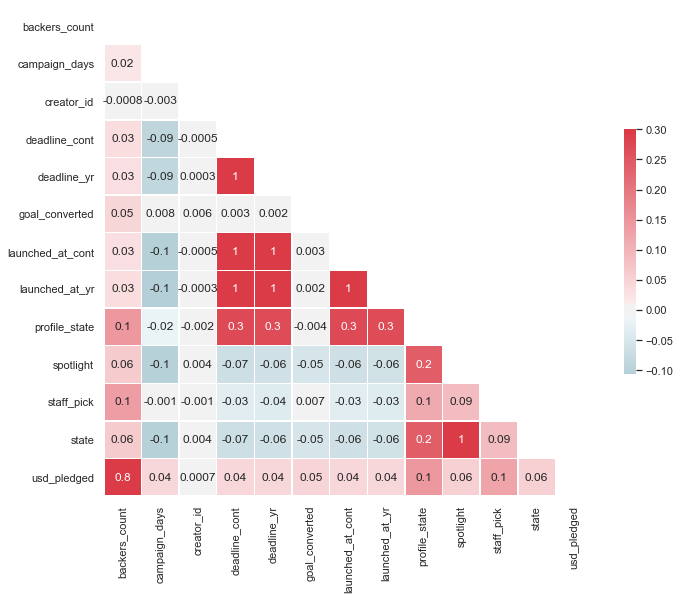

In [188]:
# Plot correlation heatmap for continuous variables
#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data_cont.corr(), dtype=np.bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data_cont.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1g");

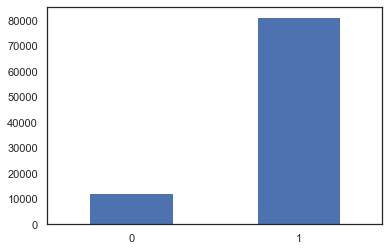

In [189]:
data['state'].value_counts(ascending=True).plot(kind='bar', rot=0);

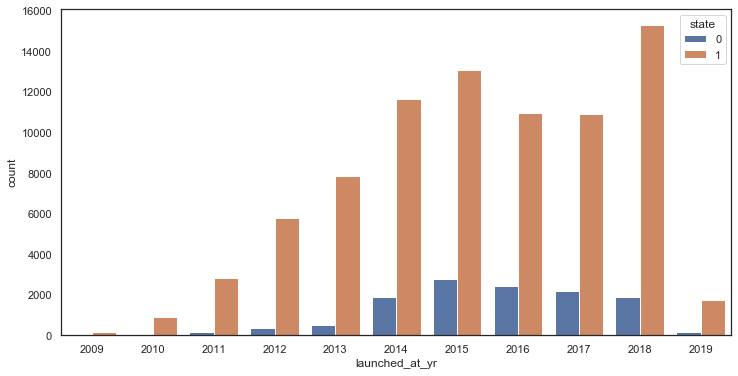

In [190]:
# Countplot
plt.figure(figsize=(12,6))
sns.countplot(x="launched_at_yr", hue="state", data=data_clean);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


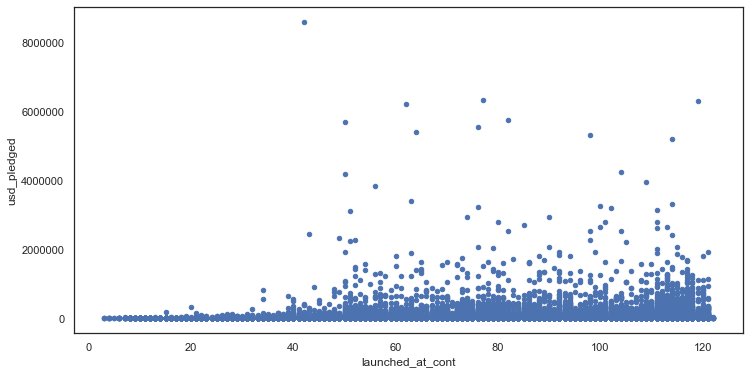

In [191]:
# Plot scatterplot of "usd_pledged" over time
data_clean.plot(kind='scatter', x='launched_at_cont', y='usd_pledged', figsize=(12,6));

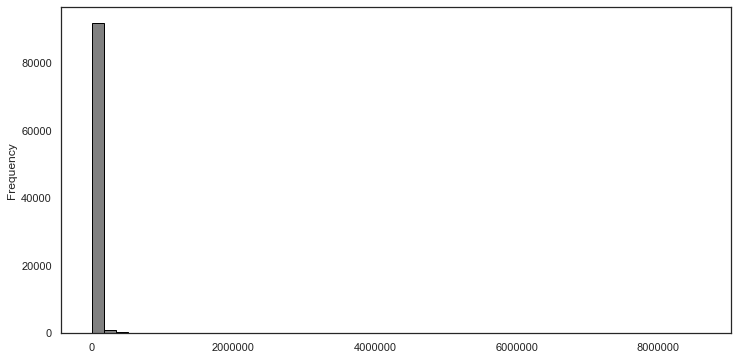

In [192]:
# Plot histogram of "usd_pledged"
data_clean['usd_pledged'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');

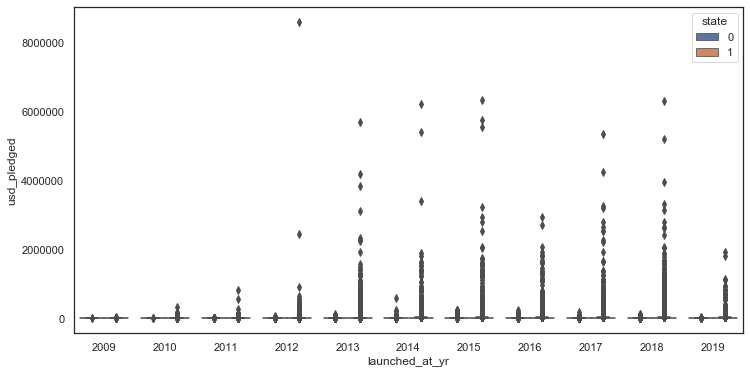

In [193]:
# Plot boxplot of "usd_pledged"
plt.figure(figsize=(12,6))
sns.boxplot(x="launched_at_yr", y="usd_pledged", data=data_clean, hue="state", boxprops=dict(alpha=.2));

In [194]:
# Plot hexbin of "usd_pledged" vs "goal_converted"

In [195]:
# Plot catplot
#sns.catplot(x="converted_pledged_amount", y='goal_converted', data=data_clean, hue='state', kind="strip", col_wrap=4);

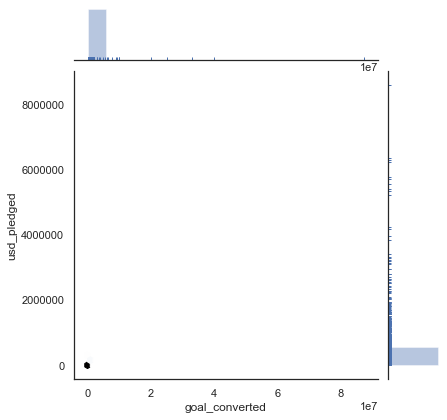

In [196]:
# Plot jointplot (1 feature)
sns.jointplot('goal_converted', 'usd_pledged', data=data_clean, kind="hex", marginal_kws=dict(bins=15, rug=True), annot_kws=dict(stat="r"), linewidth=1);

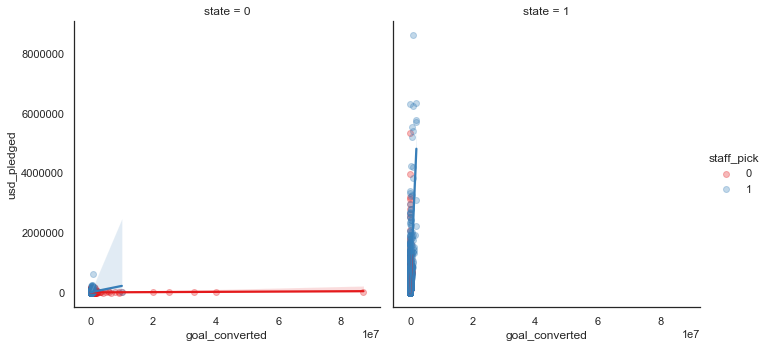

In [197]:
# Plot lmplot (3 features)
sns.lmplot(y='usd_pledged', x='goal_converted', data=data_clean, hue='staff_pick', \
           col='state', palette='Set1', scatter_kws={'alpha':0.3});

In [198]:
data.columns

Index(['backers_count', 'campaign_days', 'category', 'category_sub', 'country',
       'creator_id', 'deadline', 'deadline_cont', 'deadline_yr',
       'goal_converted', 'launched_at', 'launched_at_cont', 'launched_at_yr',
       'profile_state', 'spotlight', 'staff_pick', 'state', 'usd_pledged'],
      dtype='object')

In [199]:
# Plot selection of variables as pairplot
#sns.pairplot(data_clean, kind="reg", vars=["backers_count", "campaign_days", "goal_converted", "launched_at_yr",
#                                          "launched_at_cont", "staff_pick", "state", "usd_pledged"], 
#             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}});

In [200]:
# Plot all variables as pairplot
#sns.pairplot(data_clean[data_cont_col], hue='state', diag_kind='kde', height=2);

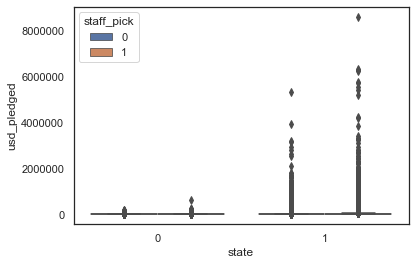

In [201]:
# Plot boxplot of avg "converted_pledged_amount" and "goal_converted" per "state"
sns.boxplot(x="state", y="usd_pledged", hue="staff_pick", data=data_clean);

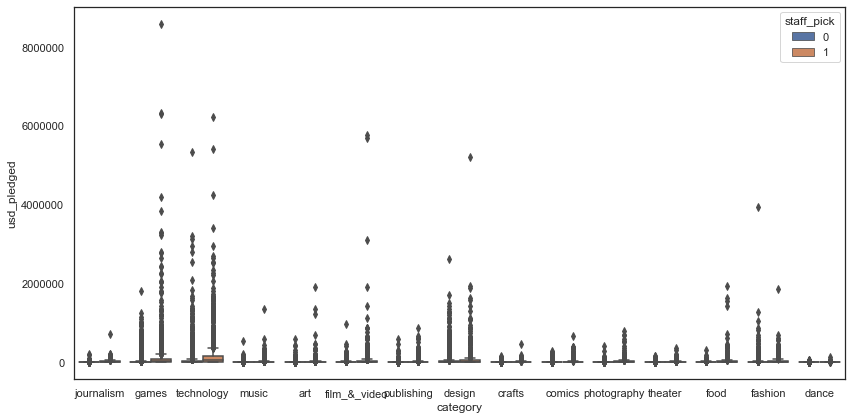

In [202]:
# Plot boxplot of avg "converted_pledged_amount" and "goal_converted" per "category"
plt.figure(figsize=(12,6))
sns.boxplot(x="category", y="usd_pledged", hue="staff_pick", data=data_clean);
plt.tight_layout()

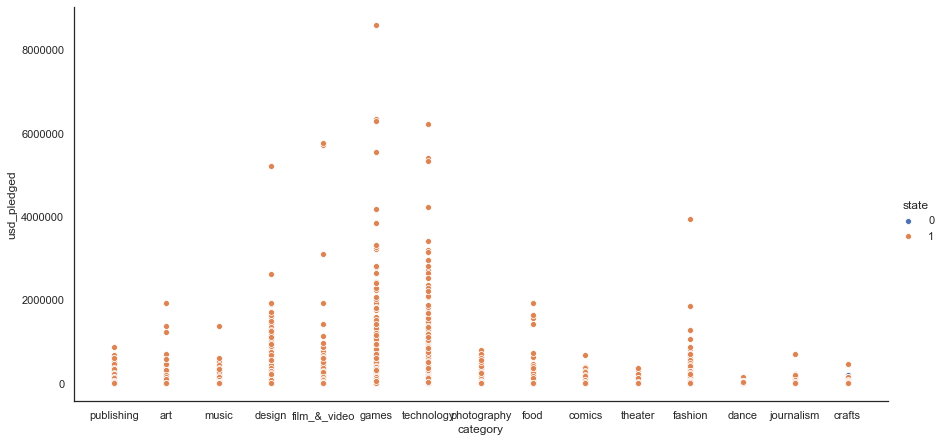

In [203]:
# Plot per category
sns.pairplot(data_clean,
             x_vars=["category"],
             y_vars=["usd_pledged"],hue='state',height=6,aspect=2);
plt.savefig("figures/fig5_pairplot.png")

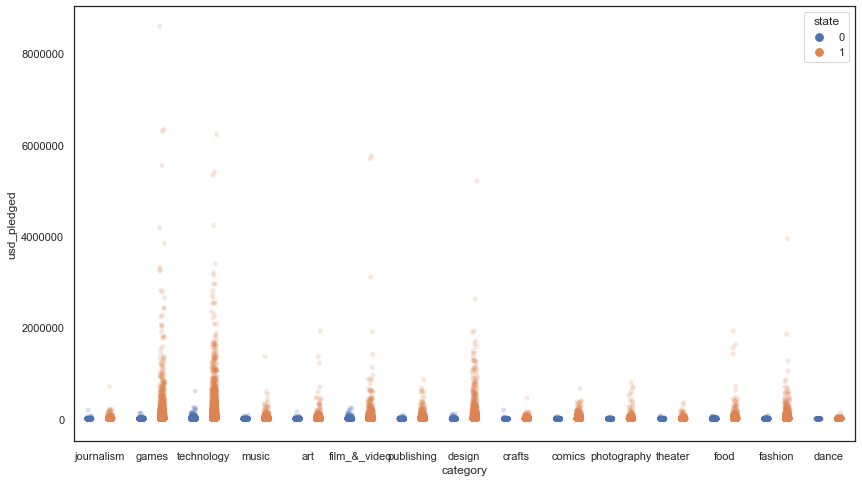

In [204]:
# Stripplot
plt.figure(figsize=(14,8))
sns.stripplot(data=data_clean,jitter=True,alpha=.2,
             x="category",
             y="usd_pledged",hue='state',size=5, dodge=True);
plt.savefig("figures/fig6_pairplot.png")

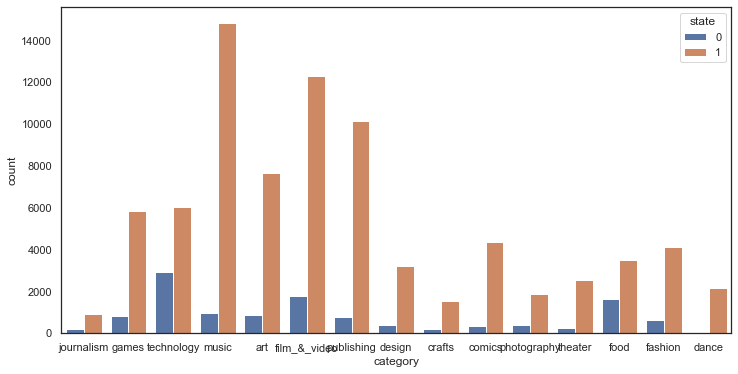

In [205]:
# Countplot
plt.figure(figsize=(12,6))
sns.countplot(x="category", hue="state", data=data_clean);

In [206]:
# Plot FacetGrid
#g = sns.FacetGrid(data_clean,
#                  col='view',
#                  row='bedrooms',
#                  hue='waterfront',
#                  palette='Set2')
#g = (g.map(plt.scatter, 'sqft_living', 'price').add_legend())

In [207]:
# Plot continuous variables
#plt.hist(data_clean.price, bins = 25);
#plt.hist(np.log(data_clean.price), bins = 25);
#plt.tight_layout()

In [208]:
# Plot skewed features (OPTIMIZE - HOW?)

In [209]:
# Plot categorical variables
#sns.stripplot(x=data_clean.condition.values, y = data_clean.price.values, 
#              jitter=0.1, alpha=0.5);

#sns.stripplot(x=data_clean.grade.values, y = data_clean.price.values,
#              jitter=0.1, alpha=0.5);

#sns.stripplot(x=data_clean.zipcode.values, y = data_clean.price.values,
#              jitter=0.1, alpha=0.5);

#sns.pointplot(x = data_clean.zipcode.values, y = data_clean.price.values,
#              order = data_clean.groupby("zipcode")["price"].mean().sort_values().index);

#plt.tight_layout()

# Feature Engineering
Purpose: Select important features and construct more meaningful ones using the raw data that you have

To-Do's:
- Start with brainstorming session to determine which features could be useful

In [210]:
# Import libraries
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline # Same, but with the latter it is not necessary to name estimator and transformer
from sklearn.compose import ColumnTransformer

In [211]:
# Reset dataset to post-clean state (optional)
data = data_clean.copy()

In [212]:
# Post-exploration drop of columns
data.drop(["deadline_cont", "deadline_yr", "launched_at_yr", "profile_state", "spotlight"], axis=1, inplace=True)

## Design new features

In [213]:
# Create 1/0 feature for highly overachieving projects vs. normal ones 
# (or continuous giving % of "converted_pledged_amount" vs. "goal_converted")

In [214]:
# Create avg backing feature (usd_pledged / backers_count)
data["usd_pledged_avg"] = data["usd_pledged"] / data["backers_count"]

In [215]:
# Create feature to represent "all others being held equal, how does the level of goal setting affect the amount of pledges?"

In [216]:
# Create "creator_project_no" from "creator_id" and "launched_at" (to see whether there are learning effects)
def count_project_no(data, column):
    id_list = []
    project_count = []
    for el in data[column]:
        id_list.append(el)
        project_count.append(id_list.count(el))
    return project_count

data["creator_project_no"] = count_project_no(data, "creator_id")

In [217]:
# Make buckets for projects (e.g. 501-5000 "low_range", 5001-50000 "mid_range", ...)

In [218]:
# Create log "usd_pledged_log" for continuous variable "usd_pledged"
data["usd_pledged_log"] = [math.log(el) for el in data["usd_pledged"]]

In [219]:
# Create log "goal_converted_log" for continuous variable "goal_converted"
data["goal_converted_log"] = [math.log(el) for el in data["goal_converted"]]

In [220]:
# Create log "backers_count_log" for continuous variable "backers_count"
data["backers_count_log"] = [math.log(el) for el in data["backers_count"]]

In [221]:
# Fill column to represent the max from two columns
#data["column1"] = data[["column1","column2"]].max(axis=1)

In [222]:
# Display histogram of log-transformed features
#data['usd_pledged_log'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');
#data['goal_converted_log'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');
#data['backers_count_log'].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');

In [223]:
# Split 2nd dataset "data_reg" for regression on "usd_pledged_log"
data_reg = data.copy()

In [224]:
# Drop features for classification "state" ("data")
data.drop(["backers_count", "backers_count_log", "category_sub", "creator_id", "deadline", 
           "goal_converted", "launched_at", "usd_pledged", "usd_pledged_log"], axis=1, inplace=True)

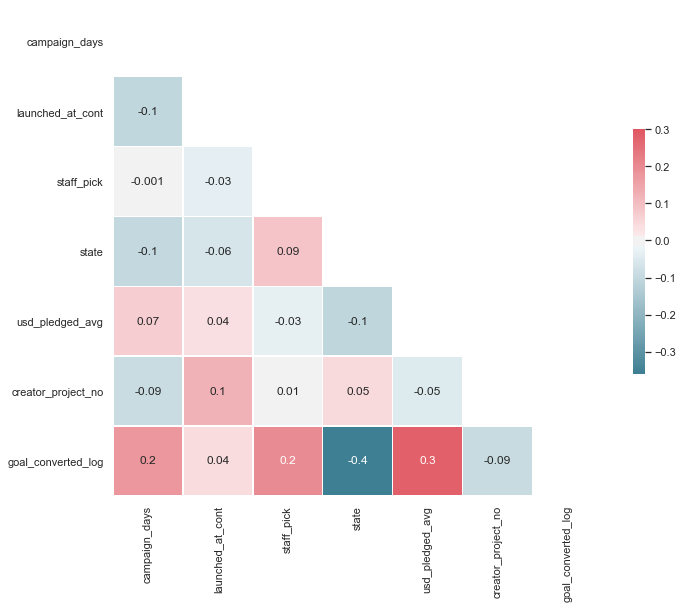

In [225]:
# Plot correlation heatmap for continuous variables
#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1g");

In [226]:
# Drop features for regression "usd_pledged_log" ("data_reg")
data_reg.drop(["backers_count", "backers_count_log", "category", "creator_id", "deadline", 
           "goal_converted", "goal_converted_log", "launched_at", "usd_pledged"], axis=1, inplace=True)

## Train/test split

### Train/test split classification ("state")

In [227]:
# Define predictors and target variable
X = data.drop(["state"], axis=1)
y = data["state"]

In [364]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,
                                                        random_state=random_state,
                                                        shuffle=True,
                                                   stratify=y) # Use stratify=y if labels are inbalanced (e.g. most wines are 5 or 6; check with value_counts()!)

### Dummy classifier (to establish baseline)

In [229]:
# Dummy classifier (requires train/test split)
dum_clf = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
y_pred_dum_clf = dum_clf.predict(X_test)

#Distribution of y test
print('y actual : \n' +  str(y_test.value_counts()))

#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_pred_dum_clf).value_counts()))

y actual : 
1    16709
0     1997
Name: state, dtype: int64
y predicted : 
1    18706
dtype: int64


### Train/test split regression ("usd_pledged_log")

In [230]:
# Define predictors and target variable
X_reg = data_reg.drop(["usd_pledged_log"], axis=1)
y_reg = data_reg["usd_pledged_log"]

In [365]:
# Split data into training and testing sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg,y_reg,test_size=test_size,
                                                        random_state=random_state,
                                                        shuffle=True) # Use stratify=Y if labels are inbalanced (e.g. most wines are 5 or 6; check with value_counts()!)

### Dummy classifier (to establish baseline)

In [232]:
# Dummy classifier (requires train/test split)
dum_clf = DummyClassifier(strategy='most_frequent').fit(X_reg_train,y_reg_train)
y_reg_pred_dum_clf = dum_clf.predict(X_reg_test)

#Distribution of y test
print('y actual : \n' +  str(y_reg_test.value_counts()))

#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_reg_pred_dum_clf).value_counts()))

y actual : 
6.907755     20
7.313220     17
7.600902     16
8.517193     15
6.908755      9
6.937314      9
7.090077      9
8.160518      9
7.090910      9
7.824046      8
7.355641      8
7.313887      8
7.824446      8
7.133296      8
8.294050      8
6.917706      7
6.944087      7
7.873217      7
8.008033      7
6.928538      7
7.064759      6
7.139660      6
6.981006      6
7.316548      6
7.689371      6
7.159292      6
8.203851      6
7.212294      6
8.045588      6
7.353722      6
             ..
8.314342      1
8.123854      1
9.628458      1
7.514919      1
10.595853     1
9.552369      1
9.451087      1
10.413147     1
11.650034     1
6.924173      1
8.612322      1
8.011271      1
9.627075      1
8.696176      1
8.083946      1
8.987697      1
9.619598      1
10.933538     1
8.234300      1
8.941075      1
9.048410      1
8.474912      1
8.489750      1
10.429251     1
8.054523      1
9.238928      1
7.375627      1
9.912479      1
7.861947      1
9.503085      1
Name: usd_pl

### Train/test split classification ("state") - reduced

In [391]:
# Define predictors and target variable
data_red = data.copy()
data_red = data_red.sample(n=3000, random_state=random_state)
print(data_red.shape)
X_red = data_red.drop(["state"], axis=1)
y_red = data_red["state"]

(3000, 9)


In [392]:
# Split data into training and testing sets
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red,y_red,test_size=test_size,
                                                        random_state=random_state,
                                                        shuffle=True,
                                                                   stratify=y_red) # Use stratify=Y if labels are inbalanced (e.g. most wines are 5 or 6; check with value_counts()!)

## Preprocessing with Pipeline
Building a pipeline always follows the same syntax. In our case we create one pipeline for our numerical features and one for our categorical features. In the end both are combined into one pipeline called "preprocessor". 

### Pipeline for imputing and scaling numerical and categorical features (classifcation)

In [233]:
# Creating list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline") 
cat_features = list(data.columns[data.dtypes==object])
cat_features

['category', 'country']

In [234]:
# Creating list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features = list(data.columns[data.dtypes!=object])
num_features.remove('state')
num_features

['campaign_days',
 'launched_at_cont',
 'staff_pick',
 'usd_pledged_avg',
 'creator_project_no',
 'goal_converted_log']

In [235]:
# Pipeline using Pipeline
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [236]:
# Saving preprocessed X_train and X_test
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

### Pipeline for imputing and scaling numerical and categorical features (regression)

In [237]:
# Creating list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline") 
cat_features_reg = list(data_reg.columns[data_reg.dtypes==object])
cat_features_reg

['category_sub', 'country']

In [238]:
# Creating list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features_reg = list(data_reg.columns[data_reg.dtypes!=object])
num_features_reg.remove('usd_pledged_log')
num_features_reg

['campaign_days',
 'launched_at_cont',
 'staff_pick',
 'state',
 'usd_pledged_avg',
 'creator_project_no']

In [239]:
# Pipeline using Pipeline
# Pipeline for numerical features
num_pipeline_reg = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline_reg = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline
preprocessor_reg = ColumnTransformer([
    ('num', num_pipeline_reg, num_features_reg),
    ('cat', cat_pipeline_reg, cat_features_reg)
])

In [240]:
# Saving preprocessed X_reg_train and X_reg_test
X_reg_train_prep = preprocessor_reg.fit_transform(X_reg_train)
X_reg_test_prep = preprocessor_reg.transform(X_reg_test)

### Pipeline for imputing and scaling numerical and categorical features (classifcation) - reduced

In [393]:
# Creating list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline") 
cat_features_red = list(data_red.columns[data.dtypes==object])
cat_features_red

['category', 'country']

In [394]:
# Creating list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features_red = list(data_red.columns[data_red.dtypes!=object])
num_features_red.remove('state')
num_features_red

['campaign_days',
 'launched_at_cont',
 'staff_pick',
 'usd_pledged_avg',
 'creator_project_no',
 'goal_converted_log']

In [395]:
# Pipeline using Pipeline
# Pipeline for numerical features
num_pipeline_red = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline_red = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline
preprocessor_red = ColumnTransformer([
    ('num', num_pipeline_red, num_features_red),
    ('cat', cat_pipeline_red, cat_features_red)
])

In [396]:
# Saving preprocessed X_train and X_test
X_train_prep_red = preprocessor_red.fit_transform(X_train_red)
X_test_prep_red = preprocessor_red.transform(X_test_red)

# Predictive Modeling: Classification ("state")
Purpose: Train machine learning models (supervised learning), evaluate their performance and use them to make predictions

In [261]:
# Import libraries
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, confusion_matrix, f1_score, precision_recall_curve, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm

## Pipeline 1: LogReg and GridSearch

### Apply logistic regression

In [367]:
# Logistic regression (using pipeline)
pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [368]:
# Logistic regression (using pipeline, making predictions using cross validation and probabilities)
y_train_pred_logreg = cross_val_predict(pipeline_logreg, X_train, y_train, cv=5)

In [369]:
# Logistic regression (using pipeline, printing results)
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred_logreg)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_pred_logreg)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred_logreg)))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_train_pred_logreg)))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_train_pred_logreg)))

Cross validation scores:
-------------------------
Accuracy: 0.88
Recall: 0.98
Precision: 0.90
F1 Score: 0.94
Confusion Matrix: 
[[ 2576  7309]
 [ 1422 63513]]


### Grid Search (Pipeline)
In order to optimize our model we will use gird search. At first we have to define a parameter space we want to search for the best parameter combination. Then we have to initiate our grid search via GridSearchCV. The last step is to use the fit method providing our training data as input.

In [386]:
# Defining hyperparameters for grid-search (C initial: [0.01, 0.1, 1, 10, 100]; adapted according to optimal results)
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.1, 0.5, 1, 5, 10, 30]
               }

grid_logreg = GridSearchCV(pipeline_logreg, param_grid=param_logreg, cv=5, scoring=scoring, 
                           verbose=5, n_jobs=-1) # scoring can also be "precision", "recall", ...

In [387]:
# Fit model
grid_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    8.7s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [388]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.90
Best parameters:
{'logreg__C': 5, 'logreg__penalty': 'l2'}


In [389]:
# Save best model as best_model
best_model_logreg = grid_logreg.best_estimator_['logreg']

### Final Evaluation

Finally we have a good model. Let's see if it also passes the final evaluation on the test data. Therefore we have to prepare the test set in the same way we did with the training data. Thanks to our pipeline it's done in a blink. :) 

In [390]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_pred_logreg = best_model_logreg.predict(X_test_prep)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_logreg)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_logreg)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_logreg)))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_logreg)))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_logreg)))

Accuracy: 0.83
Recall: 0.95
Precision: 0.87
F1 Score: 0.91
Confusion Matrix: 
[[  140  2331]
 [  850 15385]]


## Pipeline 2: AdaBoost and GridSearch

### Apply logistic regression

In [ ]:
# Logistic regression (using pipeline)
pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [ ]:
# Logistic regression (using pipeline, making predictions using cross validation and probabilities)
y_train_predicted = cross_val_predict(pipeline_logreg, X_train, y_train, cv=5)

In [ ]:
# Logistic regression (using pipeline, printing results)
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

### Grid Search (Pipeline)
In order to optimize our model we will use grid search. At first we have to define a parameter space we want to search for the best parameter combination. Then we have to initiate our grid search via GridSearchCV. The last step is to use the fit method providing our training data as input.

In [ ]:
# Defining parameter space for grid-search. Since we want to access the classifier step in our pipeline 
# we have to add 'logreg__' infront of the corresponding hyperparameters. 
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.01, 0.1, 1, 10, 100]
               }

grid_logreg = GridSearchCV(pipeline_logreg, param_grid=param_logreg, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1) # scoring can also be "precision", "recall", ...

In [ ]:
# Fit model
grid_logreg.fit(X_train, y_train)

In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

In [ ]:
# Save best model as best_model
best_model = grid_logreg.best_estimator_['logreg']

### Final Evaluation

Finally we have a good model. Let's see if it also passes the final evaluation on the test data. Therefore we have to prepare the test set in the same way we did with the training data. Thanks to our pipeline it's done in a blink. :) 

In [ ]:
# Preparing the test set 
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

### Feature importance with AdaBoost

In [ ]:
# Train a supervised learning model that has 'feature_importances_'
model = AdaBoostClassifier().fit(X_train,y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

In [ ]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

## KNeighbors Classifier

### Apply KNeighborsClassifier

In [375]:
# Logistic regression (using pipeline)
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

### Grid Search (Pipeline)
In order to optimize our model we will use grid search. At first we have to define a parameter space we want to search for the best parameter combination. Then we have to initiate our grid search via GridSearchCV. The last step is to use the fit method providing our training data as input.

In [376]:
# Defining hyperparameter space for grid-search
param_knn = {'knn__leaf_size': list(range(1,50)),
             'knn__n_neighbors': list(range(1,30))}

grid_knn = GridSearchCV(pipeline_knn, param_grid=param_knn, cv=5, scoring=scoring, 
                           verbose=4, n_jobs=-1) # scoring can also be "precision", "recall", ...

In [377]:
# Fit model
grid_knn.fit(X_train_red, y_train_red)

Fitting 5 folds for each of 1421 candidates, totalling 7105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 1740 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 2378 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 3112 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 3946 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5906 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 7032 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7098 out of 7105 | elapsed:  2.3min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 7105 out of 7105 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [378]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_knn.best_score_))
print("Best parameters:\n{}".format(grid_knn.best_params_))

Best score:
0.90
Best parameters:
{'knn__leaf_size': 1, 'knn__n_neighbors': 2}


In [379]:
# Save best model as best_model
best_model_knn = grid_knn.best_estimator_['knn']

### Final Evaluation

Finally we have a good model. Let's see if it also passes the final evaluation on the test data. Therefore we have to prepare the test set in the same way we did with the training data. Thanks to our pipeline it's done in a blink. :) 

In [380]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_pred_knn = best_model_knn.predict(X_test_prep_red)

print("Accuracy: {:.2f}".format(accuracy_score(y_test_red, y_pred_knn)))
print("Recall: {:.2f}".format(recall_score(y_test_red, y_pred_knn)))
print("Precision: {:.2f}".format(precision_score(y_test_red, y_pred_knn)))
print("F1 Score: {:.2f}".format(f1_score(y_test_red, y_pred_knn)))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test_red, y_pred_knn)))

Accuracy: 0.69
Recall: 0.78
Precision: 0.85
F1 Score: 0.81
Confusion Matrix: 
[[ 39 162]
 [266 933]]


## Random Forest Classifier

In [423]:
# Create model
pipeline_rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_clf', RandomForestClassifier(n_estimators=100,
                              random_state=random_state,
                              max_depth=5,
                              max_features="sqrt",
                              n_jobs=-1))
])

In [424]:
y_train_pred_rf_clf = cross_val_predict(pipeline_rf_clf, X_train, y_train, cv=5)

In [425]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred_rf_clf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_pred_rf_clf)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred_rf_clf)))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_train_pred_rf_clf)))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_train_pred_rf_clf)))

Cross validation scores:
-------------------------
Accuracy: 0.87
Recall: 1.00
Precision: 0.87
F1 Score: 0.93
Confusion Matrix: 
[[    0  9885]
 [    0 64935]]


In [433]:
# Defining hyperparameter space for grid-search
param_grid = {'rf_clf__bootstrap': [True, False],
              'rf_clf__max_depth': [2, 3, 5, 10, 20, None],
              'rf_clf__max_features': ['auto', 'sqrt'],
              'rf_clf__min_samples_leaf': [1, 2, 4],
              'rf_clf__min_samples_split': [2, 5, 10],
              'rf_clf__n_estimators': [10, 50, 100, 200, 400]} # Others: kernel, degree (only for poly)
grid_rf_clf = GridSearchCV(pipeline_rf_clf, param_grid, cv=5, scoring=scoring, 
                           verbose=4, n_jobs=-1)

In [434]:
# Fit on training data
grid_rf_clf.fit(X_train_red, y_train_red)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2957 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 4133 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 4794 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | e

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [435]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_rf_clf.best_score_))
print("Best parameters:\n{}".format(grid_rf_clf.best_params_))

Best score:
0.89
Best parameters:
{'rf_clf__bootstrap': False, 'rf_clf__max_depth': None, 'rf_clf__max_features': 'auto', 'rf_clf__min_samples_leaf': 1, 'rf_clf__min_samples_split': 2, 'rf_clf__n_estimators': 10}


In [436]:
# Save best model as best_model
best_model_rf_clf = grid_rf_clf.best_estimator_['rf_clf']

In [437]:
y_pred_rf_clf = best_model_rf_clf.predict(X_test_prep_red)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_rf_clf)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_rf_clf)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_rf_clf)))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf_clf)))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_rf_clf)))

ValueError: Found input variables with inconsistent numbers of samples: [18706, 600]

In [ ]:
plt.plot(rf_clf.feature_importances_)
plt.xticks(np.arange(X_train.shape[1]), X_train.columns.tolist(), rotation=90)

In [ ]:
list(zip(X_train_prep_red, rf_clf.feature_importances_))

## Support Vector Machine

### Apply SVM

In [353]:
# Kernel SVC (radial basis function)
pipeline_svc = Pipeline([
    ('preprocessor', preprocessor_red),
    ('svc', SVC(kernel='rbf', C=1E6))
])
#svc_clf_rbf = SVC(kernel='rbf', C=1E6)
#svc_clf_rbf.fit(X_train_prep_red, y_train_red)

In [354]:
# Tune model with GridSearchCV (find optimal C)
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005],
             'svc__kernel': ["linear", "rbf", "poly"]} # Others: kernel, degree (only for poly)
grid_svc = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring=scoring, 
                           verbose=4, n_jobs=-1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s


CPU times: user 465 ms, sys: 18.2 ms, total: 483 ms
Wall time: 1.75 s


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [ ]:
# Fit on training data
%time grid_svc.fit(X_train_red, y_train_red)
#print(grid.best_params_)

In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_svc.best_score_))
print("Best parameters:\n{}".format(grid_svc.best_params_))

In [ ]:
# Save best model as best_model
best_model_svc = grid_svc.best_estimator_['rf_clf']

### Final Evaluation

In [357]:
y_pred_svc = best_model_svc.predict(X_test_prep_red)

print("Accuracy: {:.2f}".format(accuracy_score(y_test_red, y_pred_svc_clf)))
print("Recall: {:.2f}".format(recall_score(y_test_red, y_pred_svc_clf)))
print("Precision: {:.2f}".format(precision_score(y_test_red, y_pred_svc_clf)))
print("F1 Score: {:.2f}".format(f1_score(y_test_red, y_pred_svc_clf)))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test_red, y_pred_svc_clf)))

Accuracy: 0.86
Recall: 1.00
Precision: 0.86
F1 Score: 0.93
Confusion Matrix: 
[[   4  190]
 [   2 1204]]


## Ensemble Methods

In [ ]:
# Call function
Stacking(rf_clf, X_train, y_train, X_test, 3)

### Gradient Boost

### AdaBoost
- Real world application: Ensemble methods are used extensively in Kaggle competitions, usually in image detection. A real world example of Adaboost is object detection in image, ex: identifying players during a game of basketball. Reference
- Strengths:
  - Ensemble methods, including Adaboost are more robust than single estimators, have improved generalizability.
  - Simple models can be combined to build a complex model, which is computationally fast.
- Weaknesses:
  - If we have a biased underlying classifier, it will lead to a biased boosted model.
- Candidacy: Ensemble methods are considered to be high quality classifiers, and adaboost is the one of most popular boosting algorithms. We also have a class imbalance in our dataset, which boosting might be robust to.

In [ ]:
# Find good application guideline (reference: notebooks/hh-2020-ds1-Ensemble-Methods-2/2_Adaboost_Codealong.ipynb)
clf_ada = AdaBoostClassifier(random_state=random_state)

### XGBoost

In [ ]:
# Determine best parameters with GridSearch
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.1, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [ ]:
# Fit model and print best parameters
csv.fit(X_train, y_train)
csv.best_params_

In [ ]:
# Create model with best parameters
xgb_clf = XGBClassifier(learning_rate=0.1, max_depth=4, min_child_weight=3)
xgb_clf.fit(X_train, y_train)

In [ ]:
# Predict values
y_pred = xgb_clf.predict(X_test)
predictions = [round(value) for value in y_pred]

## Model Optimization

### RandomizedSearchCV (alt. to GridSearchCV), here: Random Forest

In [ ]:
# Fit optimized RandomForestClassifier

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state=random_state)

# Create the random search model
rs_rf_clf = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=random_state)

# Fit 
rs_rf_clf.fit(X_train, y_train)

In [ ]:
# Display best parameters
rs_rf_clf.best_params_

In [ ]:
# Use best model for predictions
best_model = rs.best_estimator_

y_train_pred = best_model.predict(train)
y_train_proba = best_model.predict_proba(train)[:, 1]

y_test_pred = best_model.predict(test)
y_test_proba = best_model.predict_proba(test)[:, 1]

### Training and Predicting Pipeline

In [ ]:
# Define function for train_predict
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm/classifier to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [ ]:
# Set classifiers (if applicable)
clf_A = DecisionTreeClassifier(random_state=101)
clf_B = SVC(random_state = 101)
clf_C = AdaBoostClassifier(random_state = 101)

In [ ]:
# Set sample sizes
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

In [ ]:
# Collect results for various sample sizes
results = {}
for clf in [clf_A, clf_B, clf_C]: # Define which classifiers shall be used
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

## Model Tuning

### Grid Search

- Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.
- Grid-searching can be applied across machine learning to calculate the best parameters to use for any given model.

In [ ]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

In [ ]:
# Create the parameters list you wish to tune (depending on the model!)
parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1),
              'base_estimator__min_child_weight' : np.arange(1, 4, 1)
             } 

In [ ]:
# Fit grid and print results
# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=0.5) 

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scorer) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train) 
print(grid_fit.best_score_)
print(grid_fit.best_params_)

# Get the estimator
best_clf = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_clf)

In [ ]:
# Predict values based on new parameters
y_pred = grid_logreg.predict(X_test)

In [ ]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

In [ ]:
# Save best model as best_model
best_model = grid_logreg.best_estimator_['logreg']

## Final Evaluation
Finally we have a good model. Let's see if it also passes the final evaluation on the test data. Therefore we have to prepare the test set in the same way we did with the training data. Thanks to our pipeline it's done in a blink. :)

### Based on Train/Test Predict/Proba

In [ ]:
# Define formula for evaluation
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [ ]:
# Call formula
evaluate_model(predictions, probs, train_predictions, train_probs)

### Based on Preprocessor Pipeline

In [ ]:
# Preparing the test set 
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      
                      ('classifier', LogisticRegression(solver='liblinear'))
                       
                      ])

In [ ]:
y_train_pred = cross_val_predict(reg, X_train, y_train,
                              cv=5,method='predict')

y_train_scores = cross_val_predict(reg, X_train, y_train,
                              cv=5,method='decision_function')

In [ ]:
print('Confusion matrix: \n\n',confusion_matrix(y_train,y_train_scores>0),'\n')
print('The accuracy for threshold 0:', round(accuracy_score(y_train,y_train_scores>0),2))
print('The f1-score:', round(f1_score(y_train,y_train_scores>0),2))


precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.xlim([-5, 5])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))

# Data Visualization
Purpose: Communicate the findings with key stakeholders using plots and interactive visualizations

In [ ]:
# Import libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, classification_report

## Print results

In [ ]:
# Print metrics
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

## Plot Visualizations

### Confusion Matrix

In [ ]:
# Define function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['class_1','class_2'],normalize= False,  title='Confusion matrix')

### Other results

In [ ]:
# mean price on date
data_results.groupby("date")["price"].mean().plot(kind="line", x="date", y="price");

## Map Visualizations

In [ ]:
# Scatter Map for deviation from predicted value (all listings)
fig = px.scatter_mapbox(data_results,
                        lat="lat",
                        lon="long",
                        hover_name="price",
                        hover_data=["sqft_above", 'floors'],
                        size='price',
                        color='res_rel',
                        color_continuous_scale=[[0, "rgb(255, 203, 100)"],[0.5, "rgb(116, 193, 185)"],[1, "rgb(116, 193, 185)"]],
                        color_discrete_sequence=["fuchsia"],
                        zoom=7,
                        height=400)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
#fig.write_html("html_fig/map_for_four_1.html")   #saved as html in html_fig
fig.show()

In [ ]:
# Density Map for deviation from predicted value (top 5 high grade listings)
fig = px.density_mapbox(data_res_high,
                        lat='lat',
                        lon='long',
                        z='res_rel',
                        radius=5,
                        color_continuous_scale="electric" ,
                        center=dict(lat=47.53, lon=-122.23),
                        zoom=7,
                        mapbox_style="open-street-map")
#fig.write_html("figures/map_price.html")
#fig.show()

# Predictive Modeling: Regression ("usd_pledged")
Purpose: Train machine learning models (supervised learning), evaluate their performance and use them to make predictions

In [ ]:
# Import libraries
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor

## Linear regression (OLS)

### Apply linear regression

In [ ]:
X_reg_train_prep2 = X_reg_train_prep.toarray()
X_reg_train_prep2 = sm.add_constant(X_reg_train_prep2)

In [ ]:
y_reg_train2 = np.asarray(y_reg_train)

In [ ]:
reg_ols = sm.OLS(y_reg_train2, X_reg_train_prep2).fit()

In [ ]:
reg_ols.summary()

## Linear regression (Scikit Learn)

### Apply linear regression

In [ ]:
reg_lr = LinearRegression()
reg_lr.fit(X_reg_train_prep, y_reg_train)

In [ ]:
y_pred_reg_lr = reg_lr.predict(X_reg_test_prep)

In [ ]:
plt.scatter(y_reg_test, y_pred_reg_lr)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
print('MAE:', metrics.mean_absolute_error(y_reg_test, y_pred_reg_lr))
print('MSE:', metrics.mean_squared_error(y_reg_test, y_pred_reg_lr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_reg_test, y_pred_reg_lr)))
print(r2_score(y_reg_test, y_pred_reg_lr))

### Final evaluation

In [ ]:
reg_lr_pred = pd.DataFrame({'actual': y_reg_test, 'predicted': y_pred_reg_lr})
reg_lr_pred.actual = [math.exp(el) for el in reg_lr_pred.actual]
reg_lr_pred.predicted = [math.exp(el) for el in reg_lr_pred.predicted]
reg_lr_pred.head(5)

In [ ]:
reg_lr_pred2 = reg_lr_pred.head(25)
reg_lr_pred2.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## KNeighborsRegression

### Apply KNeighbors Regression

In [ ]:
reg_knr = KNeighborsRegressor()
reg_knr.fit(X_reg_train_prep, y_reg_train)

In [ ]:
y_pred_reg_knr = reg_knr.predict(X_reg_test_prep)

In [ ]:
plt.scatter(y_reg_test, y_pred_reg_knr)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
print('MAE:', metrics.mean_absolute_error(y_reg_test, y_pred_reg_knr))
print('MSE:', metrics.mean_squared_error(y_reg_test, y_pred_reg_knr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_reg_test, y_pred_reg_knr)))
print(r2_score(y_reg_test, y_pred_reg_knr))

### Final Evaluation

In [ ]:
reg_knr_pred = pd.DataFrame({'actual': y_reg_test, 'predicted': y_pred_reg_knr})
reg_knr_pred.actual = [math.exp(el) for el in reg_knr_pred.actual]
reg_knr_pred.predicted = [math.exp(el) for el in reg_knr_pred.predicted]
reg_knr_pred.head(5)

In [ ]:
reg_knr_pred2 = reg_knr_pred.head(25)
reg_knr_pred2.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## RANSACRegressor

### Apply RANSAC Regression

In [ ]:
reg_rr = RANSACRegressor()
reg_rr.fit(X_reg_train_prep, y_reg_train)

In [ ]:
y_pred_reg_rr = reg_rr.predict(X_reg_test_prep)

In [ ]:
plt.scatter(y_reg_test, y_pred_reg_rr)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
print('MAE:', metrics.mean_absolute_error(y_reg_test, y_pred_reg_rr))
print('MSE:', metrics.mean_squared_error(y_reg_test, y_pred_reg_rr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_reg_test, y_pred_reg_rr)))
print(r2_score(y_reg_test, y_pred_reg_rr))

### Final Evaluation

In [ ]:
reg_rr_pred = pd.DataFrame({'actual': y_reg_test, 'predicted': y_pred_reg_rr})
reg_rr_pred.actual = [math.exp(el) for el in reg_rr_pred.actual]
reg_rr_pred.predicted = [math.exp(el) for el in reg_rr_pred.predicted]
reg_rr_pred.head(5)

In [ ]:
reg_rr_pred2 = reg_rr_pred.head(25)
reg_rr_pred2.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Findings and Recommendations
Purpose: Summarize the key outcomes and findings of this project

- xyz
- xyz

# Future Work
Purpose: Validate and extend findings of this project

- Inclusion of further variables (e.g. ...)
- Inclusion of further publicly available data (e.g. [Kaggle Competition](https://www.kaggle.com/kemical/kickstarter-projects))
- Analyze in more detail the reasons behind cases where converted_pledged_amount < goal but state == "successful" (exchange rates?)
- Streamline pipelines / reduce redundancies in code

# References and Useful Links/Blogs

## References

### Transformers and Pipelines

Sometimes you might want to transform your features in a very specific way, which is not implemented in scikit-learn yet. In those cases you can create your very own custome transformers. In order to work seamlessly with everything scikit-learn provides you need to create a class and implement the three methods .fit(), .transform() and .fit_transform().
Two useful base classes on which you can construct your personal transformer can be imported with the following command:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

If you want to learn more about building your own transformers or pipelines in general I would recommend to have a look at the following books:

- Introduction to Machine Learning with Python by Müller and Guido (2017), Chapter 6
- Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow by Geron (2019), Chapter 2

## Useful Links/Blogs
- [Data Preprocessing Concepts (Theory)](https://towardsdatascience.com/data-preprocessing-concepts-fa946d11c825)
- [Data Preprocessing in Practice](https://towardsdatascience.com/data-preprocessing-in-python-b52b652e37d5)
- [Data Preprocessing in Practice (2)](https://medium.com/analytics-vidhya/how-to-apply-preprocessing-steps-in-a-pipeline-only-to-specific-features-4e91fe45dfb8)
- [Data Exploration (EDA)](https://towardsdatascience.com/an-extensive-guide-to-exploratory-data-analysis-ddd99a03199e)
- [Feature Engineering](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html)
- [Pipeline in ML (SVM) with Scikit-learn: A Simple Example](https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976)
- [Pipeline in ML (Decision Trees)](https://towardsdatascience.com/understanding-decision-tree-classification-with-scikit-learn-2ddf272731bd)
- [Hyperparameters and Model Validation](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html)
- [Hyperparameter Tuning (Focus Random Forest)](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
- [Grid Search for Model Tuning](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)
- [Model Selection for Regression Task: Choosing Scikit Learn LinReg Algorithm](https://towardsdatascience.com/choosing-a-scikit-learn-linear-regression-algorithm-dd96b48105f5)
- [Using ML to predict Kickstarter success](https://towardsdatascience.com/using-machine-learning-to-predict-kickstarter-success-e371ab56a743)